<a href="https://colab.research.google.com/github/mahata-lab/Tungsten-Ductile-Brittle-Temperature/blob/main/Ductility_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading and Analysis

In [140]:
!wget https://raw.githubusercontent.com/mahata-lab/Tungsten-Ductile-Brittle-Temperature/main/Created_Datasets/RT_W_with_ROM.csv

--2025-11-10 21:36:39--  https://raw.githubusercontent.com/mahata-lab/Tungsten-Ductile-Brittle-Temperature/main/Created_Datasets/RT_W_with_ROM.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54529 (53K) [text/plain]
Saving to: ‘RT_W_with_ROM.csv.5’

RT_W_with_ROM.csv.5 100%[===================>]  53.25K  --.-KB/s    in 0.002s  

2025-11-10 21:36:39 (29.5 MB/s) - ‘RT_W_with_ROM.csv.5’ saved [54529/54529]



In [141]:
import pandas as pd

data = pd.read_csv('/content/RT_W_with_ROM.csv')
data.drop(columns = ['composition','elements'],inplace=True)

# columns that won't be used (duplicate or otherwise)
data.drop(columns = ['allen pairwise mismatch','bulk modulus R_AVG','youngs modulus R_AVG','poissons ratio R_AVG','shear modulus R_AVG'], inplace=True)

# make sure only not nans
data = data[data.loc[:,'is_ductile'].notna()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68 entries, 0 to 84
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0.1                68 non-null     int64  
 1   Unnamed: 0                  68 non-null     int64  
 2   phases                      27 non-null     object 
 3   hardness (HV)               22 non-null     float64
 4   temperature (C)             68 non-null     float64
 5   compressive ys (MPa)        39 non-null     float64
 6   compressive strength (MPa)  39 non-null     float64
 7   compressive strain (%)      55 non-null     float64
 8   doi                         68 non-null     object 
 9   ys (MPa)                    12 non-null     float64
 10  uts (MPa)                   13 non-null     float64
 11  elongation (%)              13 non-null     float64
 12  pmg_comp                    68 non-null     object 
 13  is_ductile                  68 non-null   

## Dataset Analysis

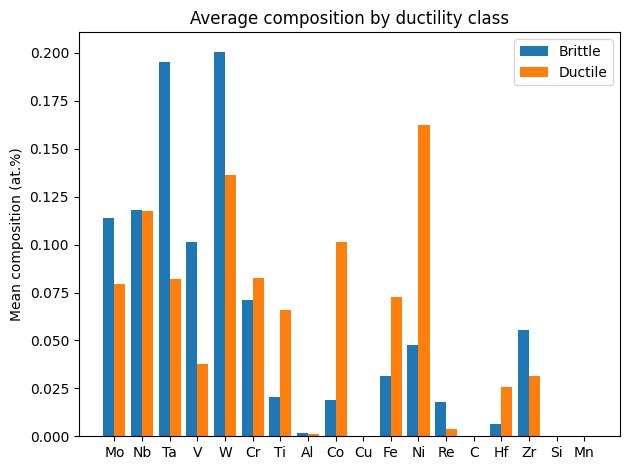

In [142]:
import matplotlib.pyplot as plt
import numpy as np

cols = data.columns[14:32]
means = data.groupby("is_ductile")[cols].mean().T  # transpose for plotting

x = np.arange(len(cols))
width = 0.4

plt.bar(x - width/2, means[False], width, label="Brittle")
plt.bar(x + width/2, means[True], width, label="Ductile")

plt.xticks(x, cols)
plt.ylabel("Mean composition (at.%)")
plt.title("Average composition by ductility class")
plt.legend()
plt.tight_layout()
plt.show()


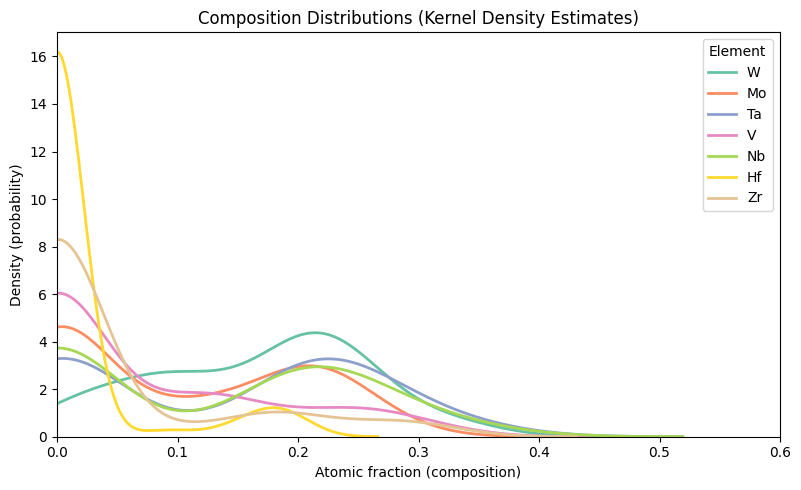

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

els = ["W", "Mo", "Ta", "V", "Nb",'Hf','Zr']
plt.figure(figsize=(8, 5))
for elem, color in zip(els,
                       sns.color_palette("Set2", len(els))):
    sns.kdeplot(
        data=data,
        x=elem,
        fill=False,
        clip=(0, 1),         # <-- restrict KDE domain
        label=elem,
        color=color,
        linewidth=2
    )

plt.legend(title="Element")
plt.xlabel("Atomic fraction (composition)")
plt.ylabel("Density (probability)")
plt.title("Composition Distributions (Kernel Density Estimates)")
plt.tight_layout()
plt.xlim(0, 0.6)
plt.show()


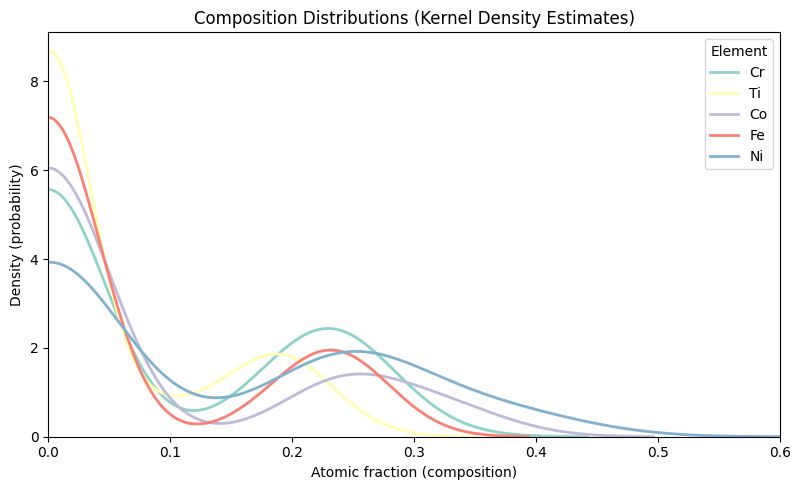

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

els = ["Cr", "Ti", "Co", "Fe","Ni"]
plt.figure(figsize=(8, 5))
for elem, color in zip(els,
                       sns.color_palette("Set3", len(els))):
    sns.kdeplot(
        data=data,
        x=elem,
        fill=False,
        clip=(0, 1),         # <-- restrict KDE domain
        label=elem,
        color=color,
        linewidth=2
    )

plt.legend(title="Element")
plt.xlabel("Atomic fraction (composition)")
plt.ylabel("Density (probability)")
plt.title("Composition Distributions (Kernel Density Estimates)")
plt.tight_layout()
plt.xlim(0, 0.6)
plt.show()

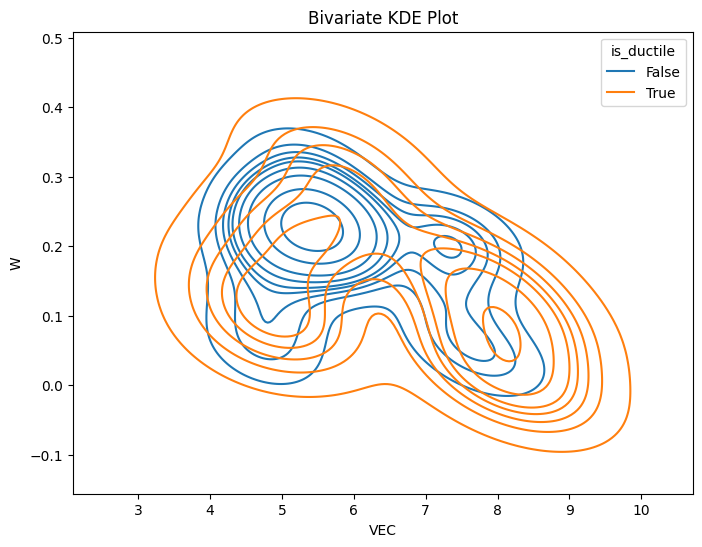

In [145]:
# Bivariate KDE plot of total_bill and tip, colored by time
plt.figure(figsize=(8, 6))
sns.kdeplot(data=data, x="VEC", y="W", hue='is_ductile', fill=False)
plt.title("Bivariate KDE Plot")
plt.show()


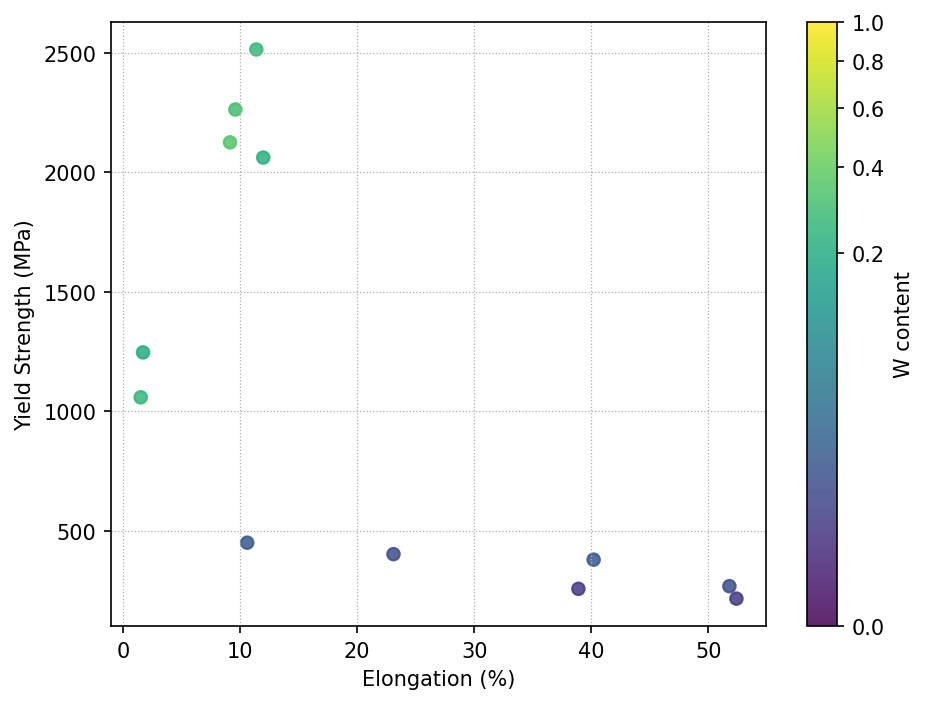

In [146]:
# DataFrame is ys_el with columns: 'ys', 'elongation', 'W'
from matplotlib.colors import PowerNorm

plt.figure(dpi=150)

norm = PowerNorm(gamma=0.3, vmin=0, vmax=max(1, data["W"].max()))  # gamma<1 => more detail near 0


sc = plt.scatter(data["elongation (%)"], data["ys (MPa)"], c=data["W"], norm=norm, s=36, alpha=0.85)
cbar = plt.colorbar(sc)
cbar.set_label("W content")

plt.xlabel("Elongation (%)")
plt.ylabel("Yield Strength (MPa)")
plt.grid(True, linestyle=":", linewidth=0.6)
plt.tight_layout()
plt.show()

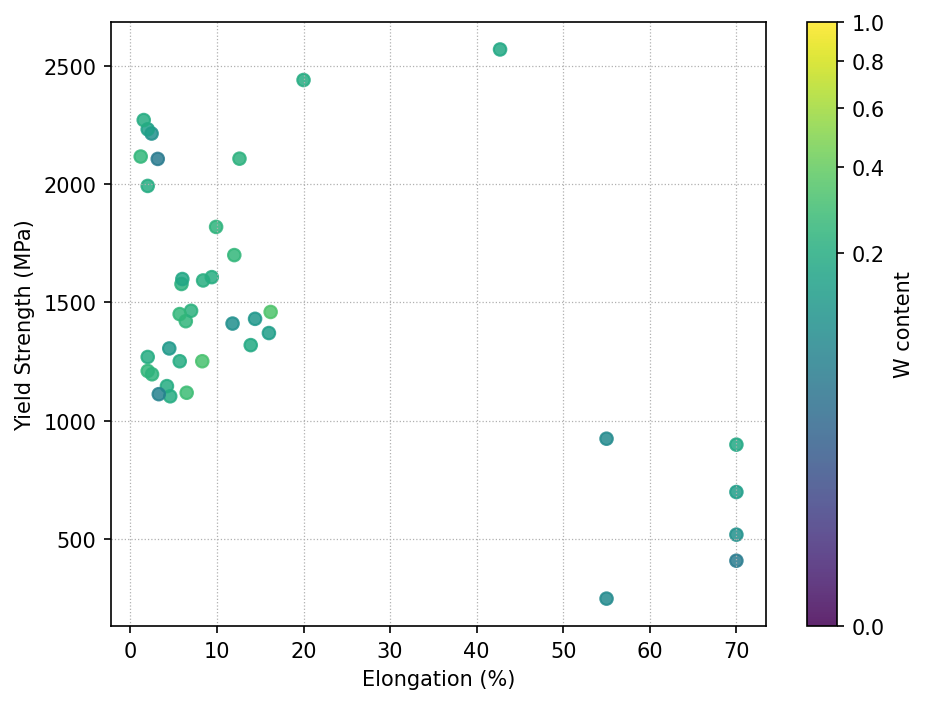

In [147]:
# DataFrame is ys_el with columns: 'ys', 'elongation', 'W'
from matplotlib.colors import PowerNorm

plt.figure(dpi=150)

norm = PowerNorm(gamma=0.3, vmin=0, vmax=max(1, data["W"].max()))  # gamma<1 => more detail near 0


sc = plt.scatter(data["compressive strain (%)"], data["compressive strength (MPa)"], c=data["W"], norm=norm, s=36, alpha=0.85)
cbar = plt.colorbar(sc)
cbar.set_label("W content")

plt.xlabel("Elongation (%)")
plt.ylabel("Yield Strength (MPa)")
plt.grid(True, linestyle=":", linewidth=0.6)
plt.tight_layout()
plt.show()

## Creating Dataset

X = features, y = target (binary ductility class)

In [148]:
# ROM features
X = data.iloc[:,32:47]
# binary ductility classification
y = data.loc[:,'is_ductile'].astype(bool)

In [149]:
y.value_counts()

,count
is_ductile,
True,37
False,31


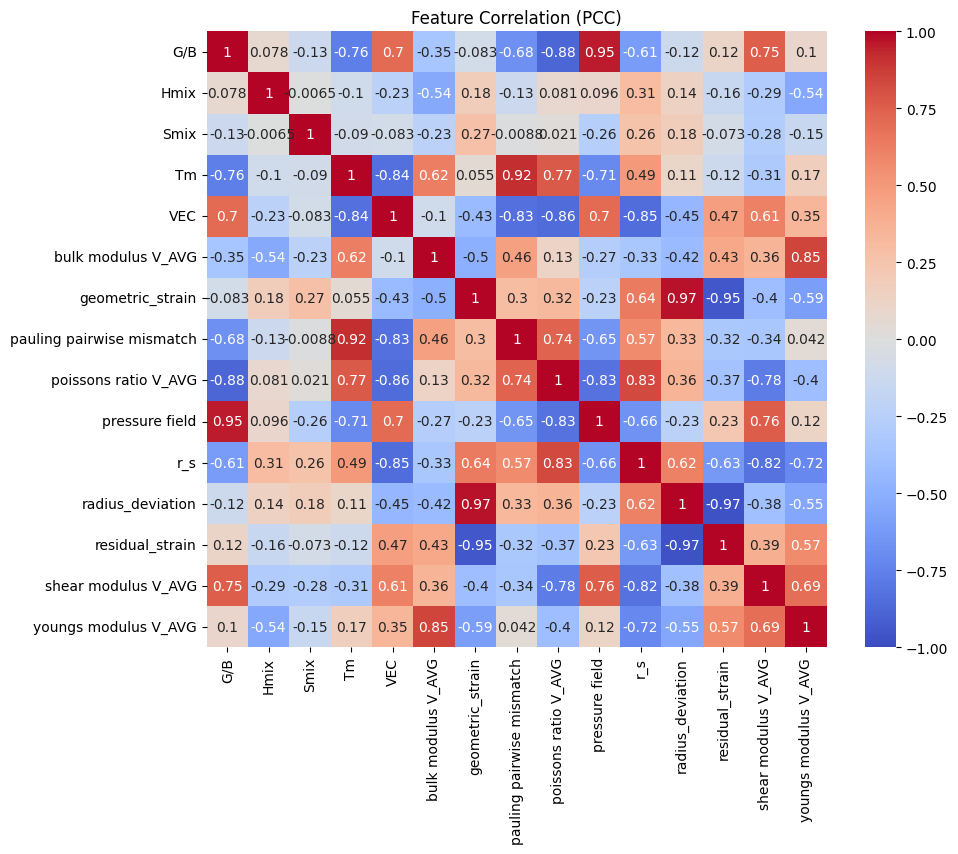

In [150]:
# look at correlation of features to reduce data size

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr = X.corr(method='pearson')
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation (PCC)')
plt.show()

In [151]:
import numpy as np

def find_correlated_features(df, threshold=0.9):
    """
    Return a list of (feature_1, feature_2, correlation) tuples
    where |corr| > threshold.
    """
    corr = df.corr().abs()
    Ucorr = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    corr_pairs = []
    for idx, row in Ucorr.iterrows():
        for col, val in row.items():
            if pd.notna(val) and val > threshold:
                corr_pairs.append((idx, col, val))

    return corr_pairs

find_correlated_features(X,threshold=0.85)


[('G/B', 'poissons ratio V_AVG', 0.8795841452924662),
 ('G/B', 'pressure field', 0.9541760448841315),
 ('Tm', 'pauling pairwise mismatch', 0.9201363268162965),
 ('VEC', 'poissons ratio V_AVG', 0.8555406614971159),
 ('bulk modulus V_AVG', 'youngs modulus V_AVG', 0.8510355687993955),
 ('geometric_strain', 'radius_deviation', 0.973767225509192),
 ('geometric_strain', 'residual_strain', 0.9475917443663779),
 ('radius_deviation', 'residual_strain', 0.9749726868227367)]

In [152]:
# choose what columns to drop based on validity of the rom calculation (interpretability and generality)
corr_col_drop = ['Tm','poissons ratio V_AVG','youngs modulus V_AVG',
                 'geometric_strain','residual_strain','pressure field']

In [153]:
# set training set to uncorrelated values
X = X.drop(columns=corr_col_drop)


In [260]:
from sklearn.model_selection import train_test_split
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# scaled training and test sets for LR and SVC
Xtr_s = pd.DataFrame(scaler.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
Xte_s = pd.DataFrame(scaler.transform(Xte), columns=Xte.columns, index=Xte.index)

# scaled total dataset for SHAP values of LR, SVC
X_s = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

# Classification Models

## Random Forest Classification

In [180]:
# training using only one set of params

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_validate, learning_curve, validation_curve
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

# random forest with default parameters --- can't do tuning with OOB due to internal bias
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=3,
                            min_samples_split=2, min_samples_leaf=2, min_weight_fraction_leaf=0.0,
                            max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
                            bootstrap=True, oob_score=balanced_accuracy_score,
                            n_jobs=-1, random_state=42, ccp_alpha=0.0)

rf.fit(Xtr, ytr)


print("traning accuracy:", balanced_accuracy_score(rf.predict(Xtr), ytr))
print("test accuracy:", balanced_accuracy_score(rf.predict(Xte), yte))

# test the out of bag validation compared to cross-validation on training set (entire dataset)
print("OOB balanced accuracy:", rf.oob_score_)

#, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
scorers = {
    "balanced": "balanced_accuracy",
    "f1": "f1"
}

cvres = cross_validate(rf, X, y, cv=cv, scoring=scorers, return_train_score=True, n_jobs=-1)
print("CV balanced accuracy:", cvres["test_balanced"].mean())
print("CV F1:", cvres["test_f1"].mean())

traning accuracy: 0.9436813186813187
test accuracy: 0.7291666666666667
OOB balanced accuracy: 0.816551724137931
CV balanced accuracy: 0.7495238095238095
CV F1: 0.7566573241000486


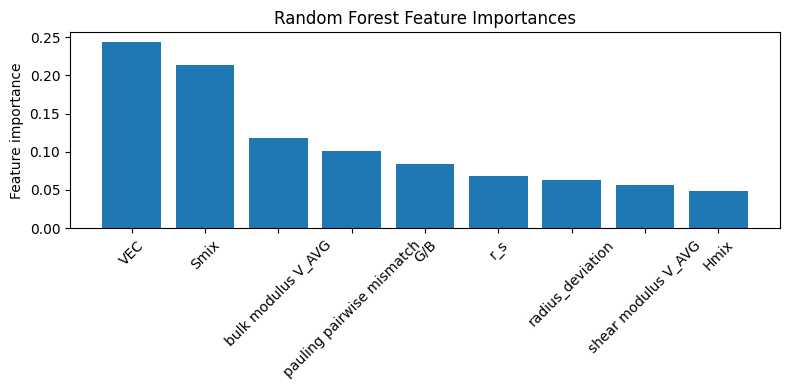

In [158]:
# impurity-based feature importance
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,4))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(X.columns)[indices], rotation=45)
plt.ylabel("Feature importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

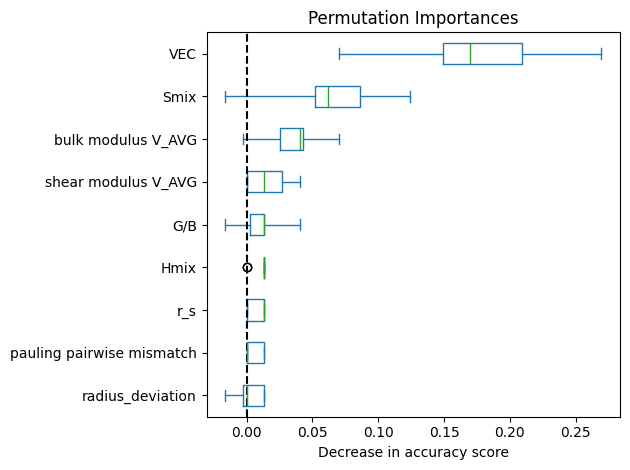

In [159]:
# permutation importance (how much the estimators rely on a feature to get correct classification)
# permutations may give a better idea of importance/weight since many of the features 'share importance'
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X, y, scoring='balanced_accuracy', n_repeats=30)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


In [160]:
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.inspection import permutation_importance

splits = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
importances = []

for train_idx, test_idx in splits.split(X):
    rf.fit(X.iloc[train_idx], y.iloc[train_idx])
    r = permutation_importance(rf, X.iloc[test_idx], y.iloc[test_idx])
    importances.append(r.importances_mean)

np.std(importances, axis=0)   # feature-wise instability


array([0.02978666, 0.01392399, 0.04761667, 0.08590455, 0.0574767 ,
       0.06482315, 0.04012735, 0.03203155, 0.05040651])

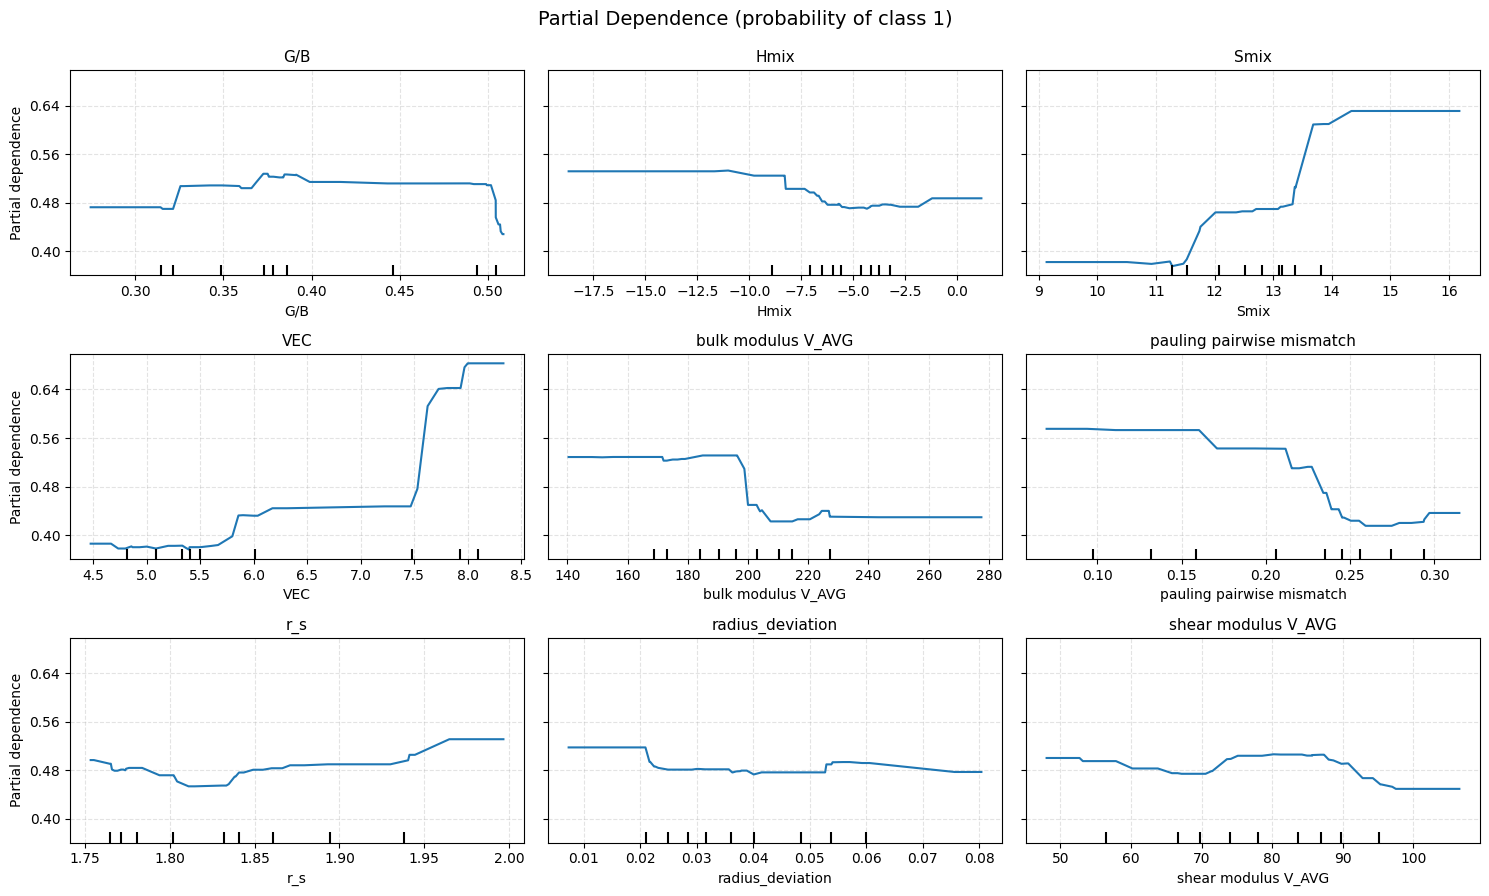

In [161]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.inspection import PartialDependenceDisplay

feats = list(X.columns)

# dynamically set number of rows and columns
ncols = 3
nrows = int(np.ceil(len(feats) / ncols))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3*nrows), sharey=True)

disp = PartialDependenceDisplay.from_estimator(
    rf, X, feats,
    ax=ax,
    kind="average",
    grid_resolution=80,
    response_method="predict_proba",
    target=1,
    percentiles=(0.05, 0.95),
)

# format subplots
axes = disp.axes_.ravel()
for i, (a, f) in enumerate(zip(axes, feats)):
    a.set_title(f, fontsize=11)
    a.grid(True, axis='both', linestyle='--', alpha=0.35)
    a.yaxis.set_major_locator(mticker.MaxNLocator(5))
    a.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
    if i % ncols != 0:  # remove redundant y-labels except first column
        a.set_ylabel("")

# remove any empty axes if len(feats) not divisible by ncols
for j in range(len(feats), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Partial Dependence (probability of class 1)", y=0.99, fontsize=14)
plt.tight_layout()
plt.show()




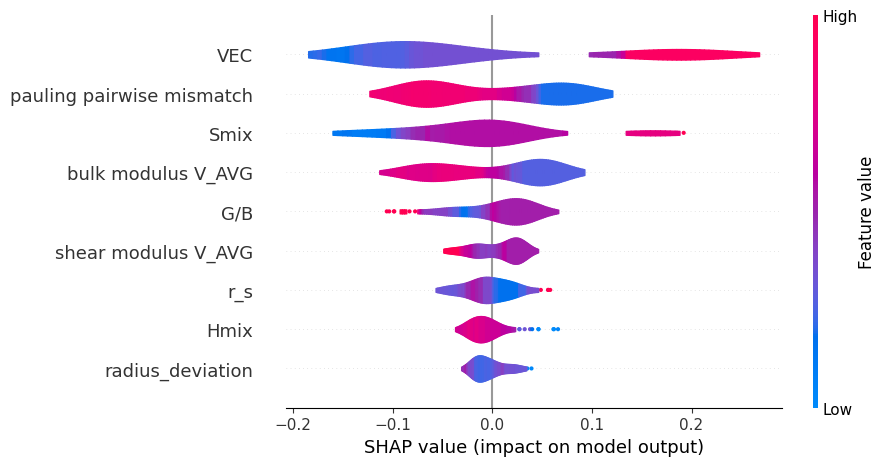

In [162]:
import shap

explainer = shap.TreeExplainer(rf)
ex = explainer(X)                      # ex.values: (n_samples, n_features, n_classes)

# pick class 1 (positive class)
shap.plots.violin(ex[:, :, 1])         # 2-D slice: (n_samples, n_features)


## Logistic Regression

In [273]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

lr_cv = LogisticRegressionCV(
        penalty="l1",
        solver="liblinear",
        Cs=np.logspace(-4, 4, 50),
        cv=cv,
        scoring="balanced_accuracy",
        class_weight="balanced",   # drop if you prefer unweighted
        fit_intercept=True,
        max_iter=10000,
        tol=1e-4,
        n_jobs=-1,
        refit=True,
        random_state=0,
        )


# use SCALED training data defined above
lr_cv.fit(Xtr_s, ytr)

LogisticRegressionCV(Cs=array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332e-02, 8.68511374e-02, 1.26485522e-01,
       1.84206997e-01, 2.68...
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                     class_weight='balanced',
                     cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                     max_iter=10000, n_jobs=-1, penalty='l1', random_state=0,
                     scoring='balanced_accuracy', solver='liblinear')

In [280]:
# test metrics using SCALED test data
test_proba = lr_cv.predict_proba(Xte_s)[:, 1]
test_pred  = (test_proba >= 0.5).astype(int)
print("test ROC AUC:", roc_auc_score(yte, test_pred))
print("test PR AUC:", average_precision_score(yte, test_pred))
print("Balanced test accuracy:", balanced_accuracy_score(yte, test_pred))

# training accuracy of SCALED training data
train_proba = lr_cv.predict_proba(Xtr_s)[:, 1]
train_pred  = (train_proba >= 0.5).astype(int)
print("train ROC AUC:", roc_auc_score(ytr, train_pred))
print("train PR AUC:", average_precision_score(ytr, train_pred))
print("Balanced training accuracy:", balanced_accuracy_score(ytr, train_pred))


print(classification_report(yte, test_pred))

test ROC AUC: 0.7291666666666667
test PR AUC: 0.7351190476190477
Balanced test accuracy: 0.7291666666666667
train ROC AUC: 0.8710344827586206
train PR AUC: 0.843778507571611
Balanced training accuracy: 0.8710344827586207
              precision    recall  f1-score   support

       False       0.62      0.83      0.71         6
        True       0.83      0.62      0.71         8

    accuracy                           0.71        14
   macro avg       0.73      0.73      0.71        14
weighted avg       0.74      0.71      0.71        14



In [283]:
# coefficients in original feature order (after scaling)
coefs = lr_cv.coef_.ravel()
odds  = np.exp(coefs)
import pandas as pd
coef_df = pd.DataFrame({"feature": getattr(X_s, "columns", np.arange(len(coefs))),
                        "coef": coefs, "odds_ratio": odds}) \
            .sort_values("coef", ascending=False).set_index('feature')
print(coef_df)

                               coef  odds_ratio
feature                                        
r_s                        3.428394   30.827094
VEC                        3.217745   24.971743
Smix                       0.318316    1.374811
shear modulus V_AVG        0.000000    1.000000
bulk modulus V_AVG         0.000000    1.000000
G/B                       -0.140610    0.868828
pauling pairwise mismatch -0.451533    0.636651
Hmix                      -0.644274    0.525044
radius_deviation          -0.721988    0.485786


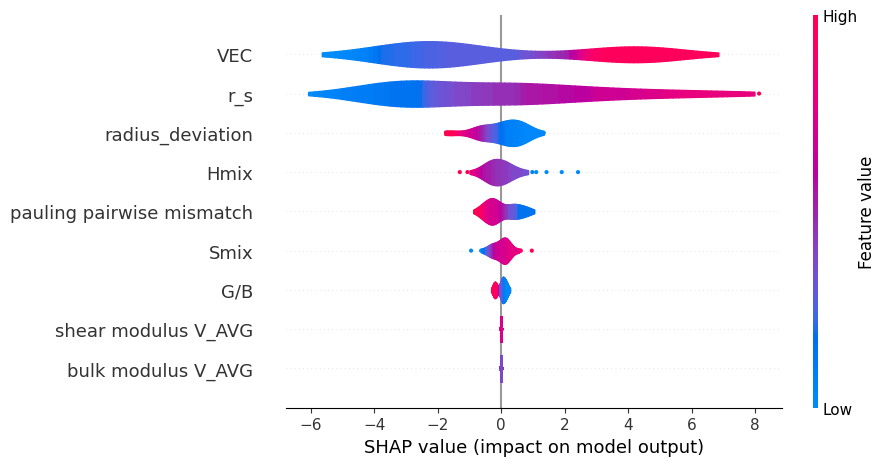

In [261]:
import shap

# X_s = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index), also above

lr_explainer = shap.Explainer(lr_cv, X_s)
lr_shap_values = lr_explainer(X_s)

# pick class 1 (positive class)
shap.plots.violin(lr_shap_values)         # 2-D slice: (n_samples, n_features)

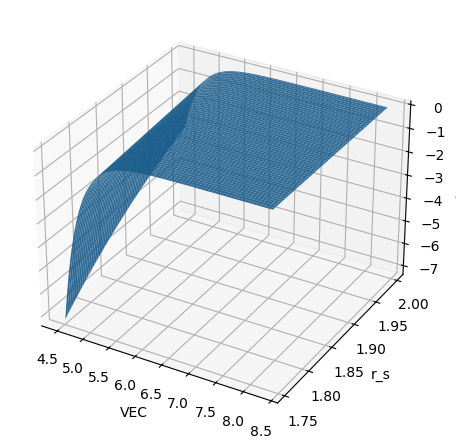

In [263]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_3d_surface(clf, X, f1, f2, target=1):
    x1 = X[f1].to_numpy(); x2 = X[f2].to_numpy()
    g1 = np.linspace(x1.min(), x1.max(), 120)
    g2 = np.linspace(x2.min(), x2.max(), 120)
    xx, yy = np.meshgrid(g1, g2)

    ref = X.median(numeric_only=True).to_dict()
    Xref = pd.DataFrame({c: ref.get(c, 0) for c in X.columns}, index=np.arange(xx.size))
    Xref[f1] = xx.ravel(); Xref[f2] = yy.ravel()

    if hasattr(clf, "predict_proba"):
        Z = clf.predict_proba(Xref)[:, target].reshape(xx.shape)
    else:
        Z = 1/(1+np.exp(-clf.decision_function(Xref))).reshape(xx.shape)

    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, Z, rstride=2, cstride=2, alpha=0.9)
    ax.set_xlabel(f1); ax.set_ylabel(f2); ax.set_zlabel("P(y=1)")
    plt.tight_layout(); plt.show()

# usage:
plot_3d_surface(lr_cv, X, "VEC", "r_s")

## Support Vector Classification

In [300]:
# use ytr and SCALED Xtr from above
from sklearn import svm

nu_lin = svm.NuSVC(nu=0.4, kernel='linear', degree=3, gamma='scale', coef0=0.0,
                   shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None,
                   verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
nu_lin.fit(Xtr_s, ytr)


nu_rbf = svm.NuSVC(nu=0.4, kernel='rbf', degree=3, gamma='scale', coef0=0.0,
                   shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None,
                   verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
nu_rbf.fit(Xtr_s, ytr)



print(f'nu_SVC, linear: {nu_lin.score(Xte_s, yte)}')
print(f'nu_SVC, rbf: {nu_rbf.score(Xte_s, yte)}')


nu_SVC, linear: 0.7142857142857143
nu_SVC, rbf: 0.7142857142857143


In [305]:
len(nu_lin.support_) / len(X_s)

0.38235294117647056

In [304]:
print(f'linear nu_SVC, train: {balanced_accuracy_score(nu_lin.predict(Xtr_s), ytr)}')
print(f'linear nu_SVC, test: {balanced_accuracy_score(nu_lin.predict(Xte_s), yte)}')
print(f'rbf nu_SVC, train: {balanced_accuracy_score(nu_rbf.predict(Xtr_s), ytr)}')
print(f'rbf nu_SVC, test: {balanced_accuracy_score(nu_rbf.predict(Xte_s), yte)}')



linear nu_SVC, train: 0.8695054945054945
linear nu_SVC, test: 0.7291666666666667
rbf nu_SVC, train: 0.9065934065934066
rbf nu_SVC, test: 0.7291666666666667


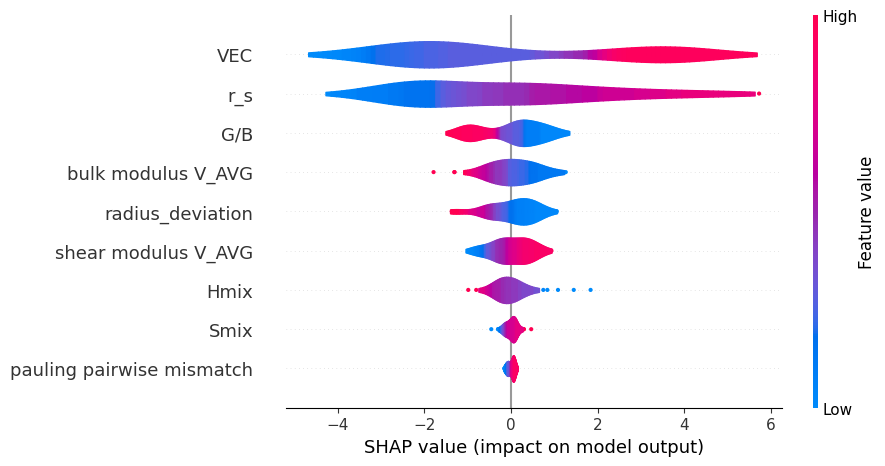

In [302]:
import shap

svc_explainer = shap.Explainer(nu_lin, X_s)
svc_shap_values = svc_explainer(X_s)

# pick class 1 (positive class)
shap.plots.violin(svc_shap_values)         # 2-D slice: (n_samples, n_features)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NuSVC was fitted with feature names
  warnings.warn(


  0%|          | 0/68 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NuSVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NuSVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NuSVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NuSVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NuSVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does n

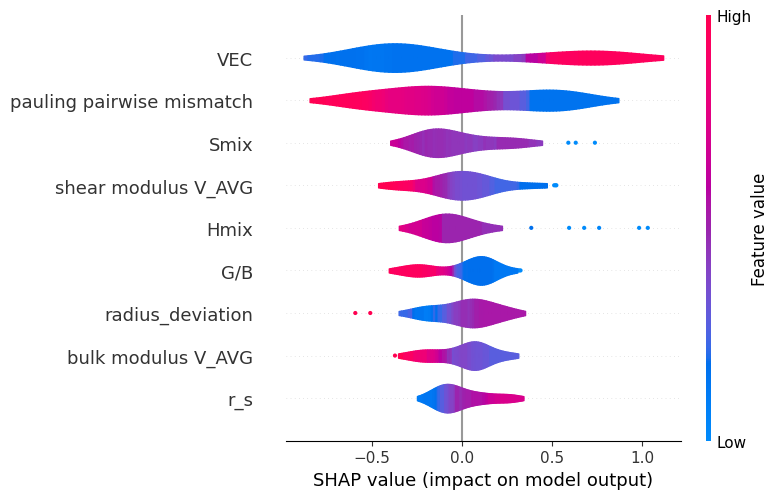

In [303]:
# X_s = scaler.transform(X)
# KernelExplainer needs a callable: f(X) → probabilities or decision values
f = lambda x: nu_rbf.decision_function(x)
# Sample background for SHAP (20–100 random points is enough)
background = shap.sample(X_s, 100, random_state=0)

# Create the explainer
nusvc_explainer = shap.KernelExplainer(f, background)

nusvc_shap_values = nusvc_explainer.shap_values(X_s)
shap.summary_plot(nusvc_shap_values, X_s, plot_type="violin")


## Accuracy of all models

In [233]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_recall_fscore_support,
    accuracy_score,
    classification_report
)

# models (scale where needed)
models = {"LogReg": lr_cv, "linSVC": lin_svc, "RandomForest": rf}


rows = []
for name, model in models.items():
    # model.fit(Xtr, ytr)
    yhat = model.predict(Xte)


    prec, rec, f1, support = precision_recall_fscore_support(yte, yhat, zero_division=0)
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        yte, yhat, average="macro", zero_division=0
    )

    prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
        yte, yhat, average="weighted", zero_division=0
    )

    rows.append({
        "model": name,
        "training set accuracy": balanced_accuracy_score(model.predict(Xtr), ytr),
        "test set accuracy": balanced_accuracy_score(model.predict(Xte), yte),
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_macro": f1_macro,
        "precision_weighted": prec_weighted,
        "recall_weighted": rec_weighted,
        "f1_weighted": f1_weighted
    })

    # optional: print per-class report
    print(f"\n=== {name} ===")
    print(classification_report(yte, yhat, digits=3, zero_division=0))

results = pd.DataFrame(rows).sort_values("f1_macro", ascending=False)



=== LogReg ===
              precision    recall  f1-score   support

       False      0.000     0.000     0.000         6
        True      0.571     1.000     0.727         8

    accuracy                          0.571        14
   macro avg      0.286     0.500     0.364        14
weighted avg      0.327     0.571     0.416        14


=== linSVC ===
              precision    recall  f1-score   support

       False      0.625     0.833     0.714         6
        True      0.833     0.625     0.714         8

    accuracy                          0.714        14
   macro avg      0.729     0.729     0.714        14
weighted avg      0.744     0.714     0.714        14


=== RandomForest ===
              precision    recall  f1-score   support

       False      0.625     0.833     0.714         6
        True      0.833     0.625     0.714         8

    accuracy                          0.714        14
   macro avg      0.729     0.729     0.714        14
weighted avg      0.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [231]:
results.round(3)

,model,training set accuracy,test set accuracy,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted
1,linSVC,0.870,0.729,0.729,0.729,0.714,0.744,0.714,0.714
2,RandomForest,0.944,0.729,0.729,0.729,0.714,0.744,0.714,0.714
0,LogReg,0.537,0.571,0.286,0.500,0.364,0.327,0.571,0.416


In [220]:
from sklearn.metrics import confusion_matrix

for name, model in models.items():
    print(name)
    print(confusion_matrix(yte, model.predict(Xte)))


LogReg
[[1 5]
 [1 7]]
linSVC
[[5 1]
 [3 5]]
RandomForest
[[5 1]
 [3 5]]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(


# Alloying strategy/visualizing decision boundary

psudo-ternary/latent space/turn forward predictions into mapping of alloy space

distribution of input elements, sample from it, generate ROM,
or distribution of ROM and calculus on input elements

decision surfaces from support vectors/logits as lagrangian constraints

## Getting distributions of new alloys from gaussian noise on existing compositions (normalize to comp sum = 1)

In [ ]:
import numpy as np
import pandas as pd

# noise around existing data

def noisy_compositions(X, noise_scale=0.02, n_samples=5, clip_zero=True, random_state=None):

    rng = np.random.default_rng(random_state)
    X = np.asarray(X, dtype=float)
    n_alloys, n_elems = X.shape

    all_noisy = []
    for i in range(n_alloys):
        # generate noise (Gaussian around 0)
        noise = rng.normal(0, noise_scale, size=(n_samples, n_elems)) + 1
        perturbed = X[i] * noise

        if clip_zero:
            perturbed = np.clip(perturbed, 0, None)

        # renormalize each composition so rows sum to 1
        perturbed /= perturbed.sum(axis=1, keepdims=True)
        all_noisy.append(perturbed)

    return np.vstack(all_noisy)




noisy_X = noisy_compositions(data.iloc[:,14:32], noise_scale=0.2, n_samples=20, random_state=42)
comps = pd.DataFrame(noisy_X, columns=data.iloc[:,14:32].columns)


In [ ]:
# fill out composition space

## ROM calculations on sampled alloys (only features from reduced set)

In [ ]:
!wget https://raw.githubusercontent.com/mahata-lab/Tungsten-Ductile-Brittle-Temperature/main/Experimental_Datasets/ROM_dataset.csv
!wget https://raw.githubusercontent.com/mahata-lab/Tungsten-Ductile-Brittle-Temperature/main/Experimental_Datasets/Hmix.csv

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


rom = pd.read_csv('/content/ROM_dataset.csv',index_col=0)
Hmix = pd.read_csv('/content/Hmix.csv',index_col=0)
rom.drop(['Atomic number'], axis=0, inplace=True)
rom.drop(['element'], axis=0, inplace=True)
rom = rom.astype(float)
rom.index

In [ ]:
def extract_nonzero(row):
    # only elements with nonzero composition
    mask = row != 0

    # extract elements and composition
    els = row.index[mask].to_numpy()
    x = row.values[mask].astype(float)
    return els, x

# get two new columns to use in functions
comps['elements'], comps['composition'] = zip(*comps.apply(extract_nonzero, axis=1))


### Radius mismatch

$
\delta r = \sqrt{\sum_{i=1}^n x_i \left(1 - \frac{r_i}{r}\right)^2}
$







In [ ]:
import numpy as np

def radius_deviation(x, r):
    """
    Atomic size mismatch parameter δ

    x : array of weights (compositions), should sum to 1
    r : array of atomic radii
    """
    x = np.asarray(x)
    r = np.asarray(r)

    rhat = np.dot(x, r)  # weighted mean radius

    # sum of elementwise products
    return np.sqrt(np.sum(x * (1 - r / rhat) ** 2))

els = ['Co','Fe','Ni']
x = np.array([0.333, 0.333, 0.333]).T
r = rom.loc['Atomic radius (pm)',els].values


print(radius_deviation(x,r))



In [ ]:
# apply radius deviation function to each row of comps using lambda row to access multiple values
comps['radius_deviation'] = comps.apply(
    lambda row: radius_deviation(
        row['composition'],
        rom.loc['Atomic radius (pm)', row['elements']].to_numpy()
    ),
    axis=1
)

comps[['elements', 'composition','radius_deviation']].head()

### Enthalpy/Entropy of Mixing


$
\Delta H^m = \sum_{i=1}^n \sum_{\substack{j=1 \\ j \ne i}}^n 4 \Delta H_{ij}^m x_i x_j
$

is really just a [quadratic form](https://en.wikipedia.org/wiki/Quadratic_form)

$\displaystyle q_{A}(x_{1},\ldots ,x_{n})=\sum _{i=1}^{n}\sum _{j=1}^{n}a_{ij}{x_{i}}{x_{j}}=\mathbf {x} ^{\mathsf {T}}A\mathbf {x}$ when A is symmetric, which it is for pairwise mixing enthalpies. The data we have is upper triangular, so we'll transform it to a symmetric matrix with the same quadratic form.

$\displaystyle B=\left({\frac {a_{ij}+a_{ji}}{2}}\right)={\frac {1}{2}}(A+A^{\text{T}})$

so that
$\Delta H^m = \mathbf {x} ^{\mathsf {T}}B\mathbf {x}$
where x is the composition vector.

Multiplying this by 4 gives the correct Hmix according to the Miedema model


In [ ]:
Hmix = pd.read_csv('/content/Hmix.csv',index_col=0)

def alloy_Hmix(els, x, Hmix):
  '''
  input:
  els (list of element name, str)
  Hmix (df of the Hmix data)

  output:
  quadratic form Hmix matrix (np.array)
  '''
  # get the pairwise Hmix for the elements in alloy - Multiply by 4 to get 4*Hmix(i,j) in each entry of the matrix
  H = 4*np.array(Hmix.loc[els][els])

  # symmetrize
  B = 1/2*(H+H.T)

  return x.T @ B @ x

# elements in the alloy
els = ['Al','Co','Fe','Ni']
# composition vector x - will be variable in the optimization process
x = np.array([0.143, 0.286, 0.286, 0.286]).T


alloy_Hmix(els,x,Hmix)


In [ ]:
Hmix = pd.read_csv('/content/Hmix.csv',index_col=0)

comps['Hmix'] = comps.apply(
    lambda row: alloy_Hmix(
        row['elements'],
        row['composition'],
        Hmix
    ),
    axis=1
)

comps[['elements', 'composition','Hmix']].head()

In [ ]:
# ΔSmix​= −R ∑​ci​*ln(ci)


def alloy_Smix(x):
  # only a function of the composition vector

  lnx = np.log(x)
  R = 8.314
  S = -R*(x @ lnx)
  return S

x = np.array([0.143, 0.286, 0.286, 0.286])
alloy_Smix(x)


In [ ]:
comps['Smix'] = comps.apply(
    lambda row: alloy_Smix(
        row['composition']
    ),
    axis=1
)

comps[['elements', 'composition','Smix']].head()

### Pairwise mismatch in electronegativity

from hume rothery

$\delta_{\chi} = \frac{\sum_{i=1}^{n} \sum_{\substack{j=1 \\ j \neq i}}^{n}
c_i c_j \left| \tfrac{\chi_i - \chi_j}{\chi} \right|}
{\sum_{i=1}^{n} \sum_{\substack{j=1 \\ j \neq i}}^{n} c_i c_j}$

the numerator is a quadradic form since it forms a symmetric matrix by default. The denominator is just a normalization factor.


In [ ]:

def pairwise_mismatch(els,x,rom,e_type='Pauling'):

  # get the vector of electronegativity of the specified type
  chi = rom.loc[f'{electronegativity_type} electronegativity (-)', els].to_numpy()
  avg_chi = np.mean(chi)
  # cast the difference of the vectors into a matrix
  diff = abs(chi[:, None] - chi[None, :])/avg_chi

  # quadratic form to get a pairwise mismatch
  pairwise_diff = x.T @ diff @ x

  # normalization
  norm = 0
  for i in range(len(x)):
    for j in range(len(x)):
      if i != j:
        norm += x[i]*x[j]

  mismatch = pairwise_diff / norm

  return mismatch

electronegativity_type ='Pauling'
# elements in the alloy
els = ['Al', 'Co', 'Fe', 'Ni']
x = np.array([0.143, 0.286, 0.286, 0.286])

pairwise_mismatch(els,x,rom)

In [ ]:
comps['pauling pairwise mismatch'] = comps.apply(
    lambda row: pairwise_mismatch(
        row['elements'],
        row['composition'],
        rom,
        e_type='Pauling'
    ),
    axis=1
)

comps[['elements', 'composition','pauling pairwise mismatch']].head()

### Voigt and Reuss averages

Voigt averages are weighted arithmetic means:

$\displaystyle V = \sum_{i=1}^n w_i P_i$


Reuss averages are weighted harmonic means:

$R = \frac{\sum_{i=1}^{n} w_i}{\sum_{i=1}^{n} \tfrac{w_i}{P_i}}$

in this case, the weights are composition, so the numerator sums to 1 every time.

The hill average is the arithmetic mean of the two bounds, and fits experimental values well for polycrystals


In [ ]:
def voigt_average(els, x, rom, prop):

  # access property vector for the chosen property and chosen elements
  Pi = rom.loc[f'{prop}',els].to_numpy()

  # arithmetic mean with dot product of composition
  P = x @ Pi
  return P


els = ['Mo', 'Nb', 'Ta', 'W']
x = np.array([0.25, 0.25, 0.25, 0.25]).T

# using both averages gives upper and lower bounds
voigt_average(els,x,rom, 'shear modulus')


In [ ]:
comps['shear modulus V_AVG'] = comps.apply(
    lambda row: voigt_average(
        row['elements'],
        row['composition'],
        rom,
        prop = 'shear modulus'
    ),
    axis=1
)

comps['bulk modulus V_AVG'] = comps.apply(
    lambda row: voigt_average(
        row['elements'],
        row['composition'],
        rom,
        prop = 'bulk modulus'
    ),
    axis=1
)

comps['r_s'] = comps.apply(
    lambda row: voigt_average(
        row['elements'],
        row['composition'],
        rom,
        prop = 'r_s'
    ),
    axis=1
)

comps['VEC'] = comps.apply(
    lambda row: voigt_average(
        row['elements'],
        row['composition'],
        rom,
        prop = 'Valence electron concentration (-)'
    ),
    axis=1
)


In [ ]:
comps['G/B']=comps['shear modulus V_AVG']/comps['bulk modulus V_AVG']

## Classification of sampled alloys

run through existing classifier(s)

In [48]:
# order comps df by dataset columns to pass through classifiers
comps[X.columns].head(2)

,G/B,Hmix,Smix,VEC,bulk modulus V_AVG,pauling pairwise mismatch,r_s,radius_deviation,shear modulus V_AVG
0,0.285874,-3.982348,13.143424,5.348002,205.753227,0.229966,1.837722,0.033201,58.819491
1,0.317333,-4.908060,13.305852,5.462130,220.605781,0.257920,1.827374,0.029827,70.005436


In [49]:
X.head(2)

,G/B,Hmix,Smix,VEC,bulk modulus V_AVG,pauling pairwise mismatch,r_s,radius_deviation,shear modulus V_AVG
0,0.311215,-4.64,13.380867,5.4,214.0,0.246486,1.83338,0.031506,66.6
1,0.314286,-6.50,11.525651,5.5,227.5,0.274716,1.83075,0.023182,71.5


In [50]:
comps['rf_prediction'] = rf.predict(comps[X.columns])
comps['LR_prediction'] = lr_cv.predict(comps[X.columns])
comps['SVC_prediction'] = lin_svc.predict(comps[X.columns])


In [51]:
comps[~comps['rf_prediction'] & ~comps['LR_prediction'] & ~comps['SVC_prediction']]

,Mo,Nb,Ta,V,W,Cr,Ti,Al,Co,Cu,...,Smix,pauling pairwise mismatch,shear modulus V_AVG,bulk modulus V_AVG,r_s,VEC,G/B,rf_prediction,LR_prediction,SVC_prediction
0,0.220986,0.164968,0.239555,0.247475,0.127015,0.000000,0.0,0.0,0.0,0.0,...,13.143424,0.229966,58.819491,205.753227,1.837722,5.348002,0.285874,False,False,False
1,0.224495,0.189040,0.183887,0.164943,0.237635,0.000000,0.0,0.0,0.0,0.0,...,13.305852,0.257920,70.005436,220.605781,1.827374,5.462130,0.317333,False,False,False
2,0.198497,0.168994,0.169631,0.229556,0.233321,0.000000,0.0,0.0,0.0,0.0,...,13.300280,0.253411,70.110839,217.368108,1.827159,5.431818,0.322544,False,False,False
3,0.186829,0.179879,0.194882,0.267891,0.170518,0.000000,0.0,0.0,0.0,0.0,...,13.262398,0.235198,63.673421,208.249883,1.835305,5.357348,0.305755,False,False,False
4,0.163331,0.220033,0.205834,0.227771,0.183032,0.000000,0.0,0.0,0.0,0.0,...,13.320760,0.235400,65.592069,209.321578,1.838373,5.346362,0.313356,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352,0.000000,0.000000,0.000000,0.127739,0.180007,0.275300,0.0,0.0,0.0,0.0,...,13.138582,0.175233,99.557636,193.298763,1.765258,7.131813,0.515045,False,False,False
1353,0.000000,0.000000,0.000000,0.099266,0.158978,0.269309,0.0,0.0,0.0,0.0,...,12.935360,0.166163,98.470251,191.074264,1.764676,7.346257,0.515351,False,False,False
1355,0.000000,0.000000,0.000000,0.110601,0.185302,0.208244,0.0,0.0,0.0,0.0,...,13.079666,0.172291,98.244988,195.078593,1.765393,7.346060,0.503617,False,False,False
1357,0.000000,0.000000,0.000000,0.110900,0.173759,0.269700,0.0,0.0,0.0,0.0,...,13.052476,0.171689,99.474722,192.638419,1.763576,7.204007,0.516380,False,False,False


##Visualization

 [Affine Transformation of Composition Simplex](https://www.sciencedirect.com/org/science/article/pii/S2635098X24002274#fig2)



In [52]:
import numpy as np
from scipy.spatial import HalfspaceIntersection, ConvexHull
from matplotlib import colormaps
import matplotlib.colors as mcolors


def get_alloy_space(comp_df, elements):
    # get the barycentric alloy space
    # elements can be individual or psuedo (grouped)

    df = comp_df.copy()
    for el in elements:
        if '_' in el:
            # split string into sub-elements (e.g. 'Mo_Nb' -> ['Mo', 'Nb'])
            combined = el.split('_')

            # sum the components of the group to form the new pseudo-element column
            df[el] = df[combined].sum(axis=1)

            # drop the original columns (if present)
            df.drop(columns=[c for c in combined if c in df.columns], inplace=True)



    # filter rows where composition sums to 1
    space = df[abs(1-df[elements].sum(axis=1))<0.001]

    return space


def ngon_vertices(n, radius=1.0, rotation=0.0):
  # get set of vertices from number of elements
  # what the simplex gets projected to

  ang = rotation + 2*np.pi*np.arange(n)/n
  V = np.c_[radius*np.cos(ang), radius*np.sin(ang)]  # (n,2)
  return V


def affine_project(c, V):
  # Given composition c (sum=1) and polygon vertex matrix V (n,2):
  # x = V^T c  (equivalently: x = c @ V)

  c = np.asarray(c)
  return c @ V


def plot_affine_map(V, points, labels, prop=None, z_name=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # vertices
    for i, (vx, vy) in enumerate(V):
        ax.scatter([vx], [vy], s=30, color='black')
        ax.text(vx*1.08, vy*1.08, f"{labels[i]}", ha='center', va='center')

    # polygon boundary
    ax.plot(*V[[*range(len(V)), 0]].T, color='black', lw=2)

    # property coloring
    if prop is not None:
        if prop.dtype == bool:
            from matplotlib.colors import ListedColormap, BoundaryNorm
            cmap = ListedColormap(['orange', 'blue'])
            norm = BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)
            sc = ax.scatter(points[:,0], points[:,1], s=60, c=prop.astype(int), cmap=cmap, norm=norm)
            cbar = plt.colorbar(sc, ax=ax, ticks=[0,1], fraction=0.03, pad=0.02, aspect=20)
            cbar.ax.set_yticklabels(['False','True'])
        else:
            sc = ax.scatter(points[:,0], points[:,1], s=90, c=prop, cmap='viridis')
            cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)

        if z_name:
            cbar.set_label(z_name, rotation=270, labelpad=10)
    else:
        ax.scatter(points[:,0], points[:,1], s=90, color='gray')

    ax.axis("off")
    ax.set_aspect("equal")
    return ax





In [53]:
data.iloc[:,14:32].columns

Index(['Mo', 'Nb', 'Ta', 'V', 'W', 'Cr', 'Ti', 'Al', 'Co', 'Cu', 'Fe', 'Ni',
       'Re', 'C', 'Hf', 'Zr', 'Si', 'Mn'],
      dtype='object')

In [54]:
# specify elements, can be single or multiple separated by underscore - DO NOT REUSE ELEMENTS
elements = ['W','Ta','V','Mo','Nb','Ti','Zr','Hf']
n = len(elements)
# get vertices to project onto
V = ngon_vertices(n, radius=1.0, rotation=np.pi/2)  # rotated 90 degrees for visual

# get the composition space
c_space = get_alloy_space(comps, elements)
# get list of just the compositions
c_list = c_space[elements]

# get list of projections of C onto V
p_list = affine_project(c_list, V)


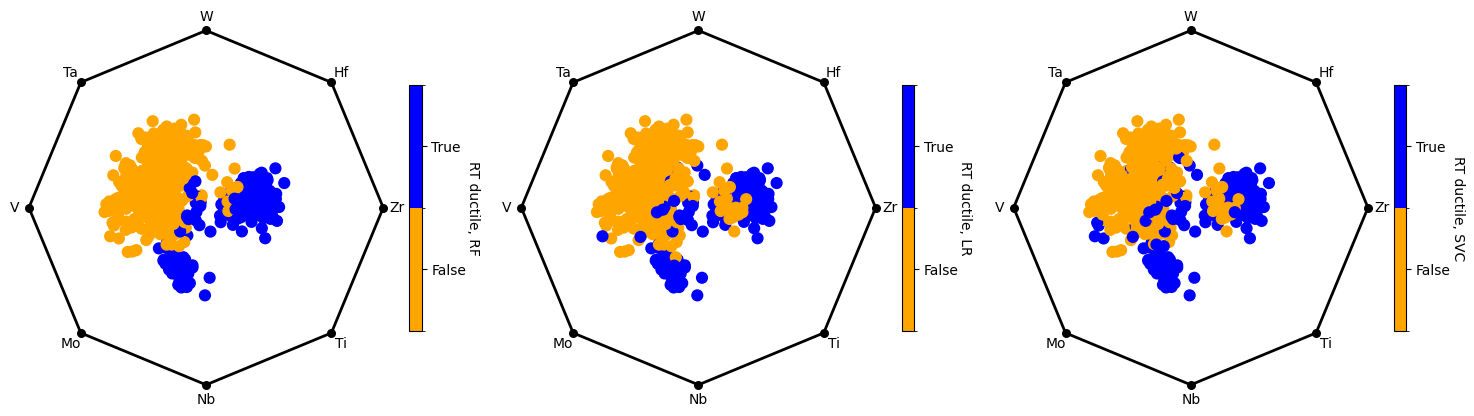

In [55]:
props = [
    ('rf_prediction', 'RT ductile, RF'),
    ('LR_prediction', 'RT ductile, LR'),
    ('SVC_prediction', 'RT ductile, SVC')
]

n = len(props)
ncols = 3
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))
axes = axes.ravel()

for ax, (col, title) in zip(axes, props):
    plot_affine_map(V, p_list, elements, c_space[col], title, ax=ax)

# turn off unused axes
for ax in axes[n:]:
    ax.axis('off')


plt.show()

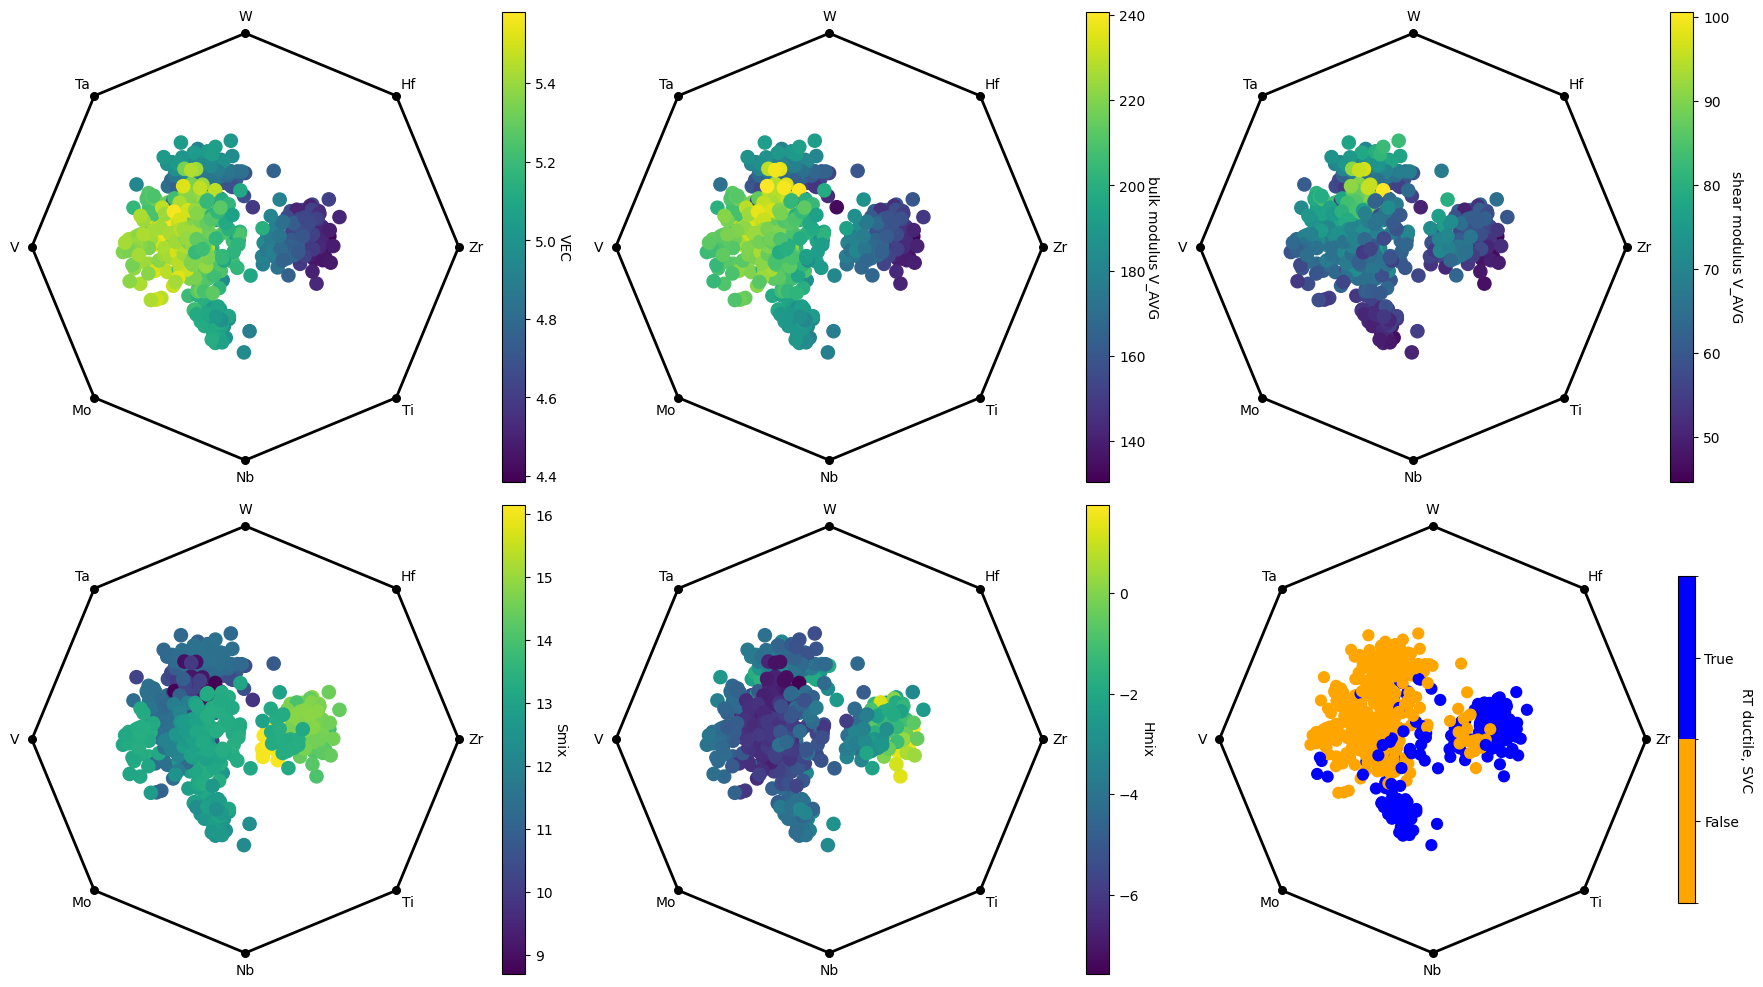

In [56]:
props = [
    ('VEC', 'VEC'),
    ('bulk modulus V_AVG', 'bulk modulus V_AVG'),
    ('shear modulus V_AVG', 'shear modulus V_AVG'),
    ('Smix', 'Smix'),
    ('Hmix', 'Hmix'),
    ('SVC_prediction', 'RT ductile, SVC')
]

n = len(props)
ncols = 3
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))
axes = axes.ravel()

for ax, (col, title) in zip(axes, props):
    plot_affine_map(V, p_list, elements, c_space[col], title, ax=ax)

# turn off unused axes
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()



<Axes: >

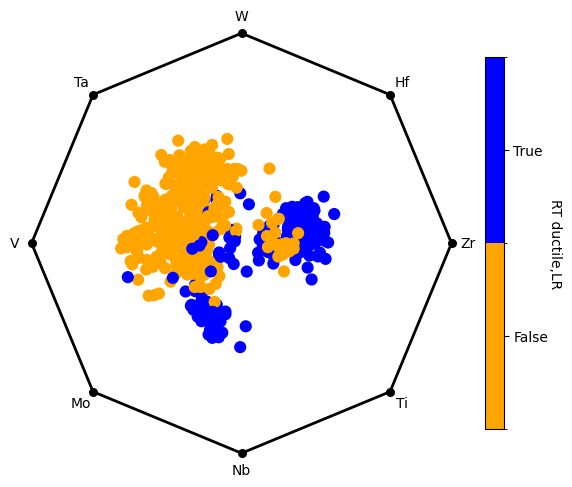

In [57]:
plot_affine_map(V, points=p_list, labels=elements, prop=c_space['LR_prediction'], z_name='RT ductile,LR')

<Axes: >

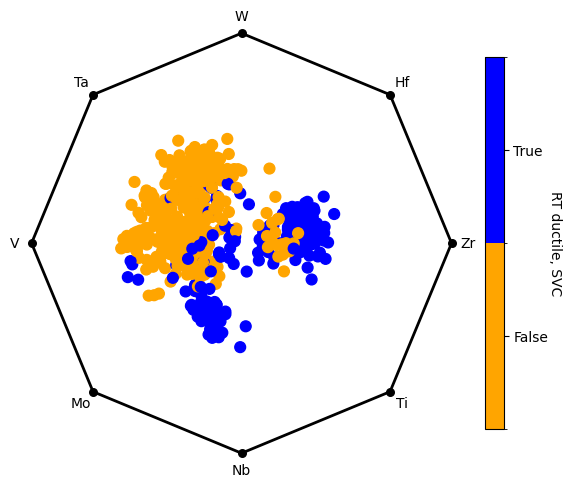

In [58]:
plot_affine_map(V, points=p_list, labels=elements, prop=c_space['SVC_prediction'], z_name='RT ductile, SVC')

# Solving for Composition Directly

Use the classification models to create distributions of ROM parameters - solve for composition for samples drawn from those distributions

In [ ]:
ROM parameters =

In [ ]:
import numpy as np

def radius_deviation(x, r):
    """
    Atomic size mismatch parameter δ

    x : array of weights (compositions), should sum to 1
    r : array of atomic radii
    """
    x = np.asarray(x)
    r = np.asarray(r)

    rhat = np.dot(x, r)  # weighted mean radius

    # sum of elementwise products
    return np.sqrt(np.sum(x * (1 - r / rhat) ** 2))

In [ ]:
exp_data = pd.read_csv('/content/RT_ROM.csv')

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, LinearConstraint, Bounds, NonlinearConstraint

element_data = pd.read_csv('/content/total_rom_dataset.csv',index_col=0)
Hmix = pd.read_csv('/content/Hmix.csv',index_col=0)
element_data.drop(['Atomic number'], axis=0, inplace=True)
element_data.drop(['element'], axis=0, inplace=True)
element_data = element_data.astype(float)
element_data.index

Index(['BCC Bulk Modulus', 'r_s', 'rho', 'Atomic radius (pm)',
       'Melting point (K)', 'Boiling point (K)',
       'Pauling electronegativity (-)', 'Allen electronegativity (-)',
       'Valence electron concentration (-)',
       'Itinerant electrons per atom (-)', 'Atomic weight (g/mol)',
       'Density (g/cm3)', 'Molar heat capacity (J/mol K)',
       'Thermal conductivity (W/m/K)', 'shear modulus', 'poissons ratio',
       'youngs modulus', 'bulk modulus'],
      dtype='object')

In [ ]:
def A_matrix(properties, elements, data):
  # Construct the list of property vectors for each element
  matrix_rows = []
  for el in elements:
      element_properties = data.loc[properties, el].to_numpy()
      matrix_rows.append(element_properties)

  # Convert the list of rows to a single NumPy matrix
  A = np.array(matrix_rows)

  # return transposed matrix to get properties in columns
  return A.T

In [ ]:
'''
construction of A matrix and variables for minimize func.
properties = vector of properties to optimize from index of data
A = matrix of properties, columns are an element each
x0 = initial composition vector
lower/upper bounds
'''

properties=['r_s','Melting point (K)']

# get vectors of properties for all of the elements in an alloy
elements = ['Mo', 'Nb', 'Ta', 'W']


bnds = Bounds(0.1, 0.3)

A = A_matrix(properties, elements, element_data)
# check that the matrix has the shape (# of properties, # of elements) so that each column is an element

# set the lower and upper fraction limits of any of the elements you want (i.e.)
#lower_bounds = {'W':0.1,'Nb':0.4}
#upper_bounds = {'Mo':0.3,'Nb':0.45}

# get the number of elements being optimized on
n = A.shape[1]

# initial equiatomic alloy -- can use existing alloy and fewer steps to optimize it (LATER)
x0 = np.ones(n)/n

In [ ]:
data[elements].loc[['shear modulus','bulk modulus']]


,Mo,Nb,Ta,W
shear modulus,20.0,38.0,67.0,161.0
bulk modulus,230.0,170.0,200.0,310.0


In [ ]:
data[elements].loc['shear modulus']/data[elements].loc['bulk modulus']

,0
Mo,0.086957
Nb,0.223529
Ta,0.335000
W,0.519355


In [ ]:
'''
construction of A matrix and variables for minimize func.
properties = vector of properties to optimize from index of data
A = matrix of properties, columns are an element each
b = target vector of properties of interest - optimizes towards that
x0 = initial composition vector
composition = sum to 1
'''

properties=['r_s','Melting point (K)']
b = [1.8, 3230]

# get vectors of properties for all of the elements in an alloy
elements = ['Mo', 'Nb', 'Ta', 'W','Ti','V','Zr']

A = A_matrix(properties, elements, data)
# check that the matrix has the shape (# of properties, # of elements) so that each column is an element

# get the number of elements being optimized on
n = A.shape[1]

# initial equiatomic alloy -- can use existing alloy and fewer steps to optimize it
x0 = np.ones(n)/n


# sum of composition vector has to be 1, and each entry has to be between 0 and 1
composition_constraint = LinearConstraint(np.ones((1,n)), 1.0, 1.0)

#bnds = construct_composition_bounds(lower_bounds,upper_bounds,elements)
bnds = Bounds(0.05, 0.3)


In [ ]:
# objective function is the squared distance between current property vector (Ax) and a target (b)
# minimize objective function given the MC1 and composition constraints

obj = lambda z: np.linalg.norm(A @ z - b)**2
res = minimize(obj, x0, method="SLSQP", constraints=[composition_constraint],
               bounds = bnds,
               options={"ftol":1e-20, "maxiter":10000})
x = res.x

print(f'elements: {elements}')
print(f'composition: {x}')
print(f'total comp: {np.sum(x)}')
print(f'result: {A@x})')
print(f'target: {b}')


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_constraints.py:530: ComplexWarning: Casting complex values to real discards the imaginary part
  y[:n_bound_below] = y_all[i_bound_below] - lb[i_bound_below]
/usr/local/lib/python3.12/dist-packages/scipy/optimize/_constraints.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  y[n_bound_below:] = -(y_all[i_bound_above] - ub[i_bound_above])


elements: ['Mo', 'Nb', 'Ta', 'W', 'Ti', 'V', 'Zr']
composition: [0.27566876 0.05       0.26536876 0.3        0.05       0.05
 0.05      ]
total comp: 1.0410375182705587
result: [1.91020599e+00 3.22999995e+03])
target: [1.8, 3230]


In [ ]:
import json

optimized = res.x
optimized = optimized*100

output = {el: val for el, val in zip(elements, optimized)}

with open('optimized.json', 'w') as f:
    json.dump(output, f)